In [1]:
import time
# Start run time
start_time = time.time()

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import pandas as pd
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
import matplotlib as mpl
import matplotlib.pyplot as plt

**Let's load the MNIST dataset from Keras:**

In [2]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()

**MNIST training set contains 60,000 grayscale images, each 28x28 pixels:**

In [3]:
X_train_full.shape

(60000, 28, 28)

**Each pixel intensity is also represented as a byte (0 to 255):**

In [4]:
X_train_full.dtype

dtype('uint8')

**Let's split the full training set into a validation set and a (smaller) training set. We also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255:**

In [5]:
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255

**In Deep Learning MLPs, its standard practice to evaluate models by splitting the train set (60000) into both train (55000) and validation (5000).
We then can observe the convergence of both loss vs validation loss curves to design deep supervised model that
will perform good curve fit on training data.
The convergance of loss vs valid loss curves also played a role in designing deep Autoencoder layers
and choosing activation functions.**

In [6]:
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]

In [7]:
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]
y_train.shape, y_valid.shape

((55000,), (5000,))

The validation set contains 5,000 images, and the test set contains 10,000 images:

In [8]:
X_valid.shape

(5000, 28, 28)

In [9]:
X_test.shape

(10000, 28, 28)

In [10]:
type(X_test)

numpy.ndarray

**Let's take a look at a sample of X_train images in the dataset:**

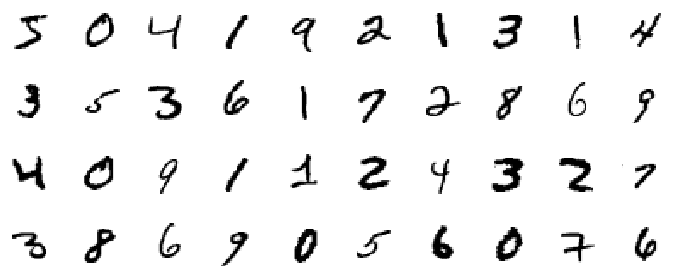

In [11]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [13]:
keras.backend.clear_session()
# Separating the encoder and decoder from model
stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(0.10),
    keras.layers.Dense(394, activation="selu"),
    keras.layers.Dense(192, activation="selu"),
    keras.layers.Dense(96, activation="selu"),
    keras.layers.Dense(48, activation="selu"),
    keras.layers.Dense(29, activation="selu")])

stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(48, activation="selu", input_shape=[29]),
    keras.layers.Dense(96, activation="selu"),
    keras.layers.Dense(192, activation="selu"),
    keras.layers.Dense(394, activation="selu"),
    keras.layers.Dense(28*28, activation="sigmoid"),
    keras.layers.Reshape([28,28])])

In [14]:
# combine both encoder and decoder to become autencoder model
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])

In [15]:
stacked_ae.compile(loss="MSE",
              optimizer=keras.optimizers.Adam())

In [16]:
stacked_encoder.compile(loss="MSE",
              optimizer=keras.optimizers.Adam())

In [17]:
stacked_decoder.compile(loss="MSE",
              optimizer=keras.optimizers.Adam())

In [18]:
stacked_encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dropout (Dropout)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 394)               309290    
_________________________________________________________________
dense_1 (Dense)              (None, 192)               75840     
_________________________________________________________________
dense_2 (Dense)              (None, 96)                18528     
_________________________________________________________________
dense_3 (Dense)              (None, 48)                4656      
_________________________________________________________________
dense_4 (Dense)              (None, 29)                1

In [19]:
stacked_decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 48)                1440      
_________________________________________________________________
dense_6 (Dense)              (None, 96)                4704      
_________________________________________________________________
dense_7 (Dense)              (None, 192)               18624     
_________________________________________________________________
dense_8 (Dense)              (None, 394)               76042     
_________________________________________________________________
dense_9 (Dense)              (None, 784)               309680    
_________________________________________________________________
reshape (Reshape)            (None, 28, 28)            0         
Total params: 410,490
Trainable params: 410,490
Non-trainable params: 0
________________________________________________

#### We are doing Unsupervised Autoencoder. So, we do not want to use y labels. Therefore, y_train, y_valid, or y_test are not needed for this training model. We will use y_train and y_test for the Supervised MLP:

In [21]:
# NOTE: Python Kernel needs to be restarted when training again for second time and so on!
early_stopping_val_loss = keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)
checkpoint_cb = keras.callbacks.ModelCheckpoint("ae_mnist_model.h5", save_best_only=True)
stacked_ae_hist = stacked_ae.fit(X_train, X_train, epochs=20,validation_data=(X_valid, X_valid),callbacks=[early_stopping_val_loss, checkpoint_cb])

#history = model.fit(X_train, X_train, epochs=20,validation_data=(X_valid, X_valid),callbacks=[early_stopping_val_loss, checkpoint_cb])

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 6s 117us/sample - loss: 0.0252 - val_loss: 0.0166
Epoch 2/20
55000/55000 [==============================] - 6s 104us/sample - loss: 0.0156 - val_loss: 0.0136
Epoch 3/20
55000/55000 [==============================] - 6s 103us/sample - loss: 0.0138 - val_loss: 0.0124
Epoch 4/20
55000/55000 [==============================] - 6s 103us/sample - loss: 0.0129 - val_loss: 0.0121
Epoch 5/20
55000/55000 [==============================] - 6s 109us/sample - loss: 0.0122 - val_loss: 0.0119
Epoch 6/20
55000/55000 [==============================] - 6s 101us/sample - loss: 0.0118 - val_loss: 0.0114
Epoch 7/20
55000/55000 [==============================] - 6s 100us/sample - loss: 0.0114 - val_loss: 0.0106
Epoch 8/20
55000/55000 [==============================] - 6s 101us/sample - loss: 0.0111 - val_loss: 0.0109
Epoch 9/20
55000/55000 [==============================] - 5s 98us/sample - loss: 0.0109

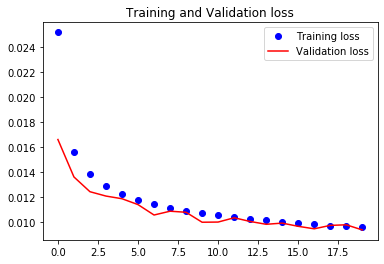

In [22]:
#acc = history.history['accuracy']
#val_acc = history.history['val_accuracy']
loss = stacked_ae_hist.history['loss']
val_loss = stacked_ae_hist.history['val_loss']

epochs = range(len(loss))

#lt.plot(epochs, acc, 'bo', label='Training acc')
#lt.plot(epochs, val_acc, 'b', label='Validation acc', color='red')
#lt.title('Training and Validation accuracy')
#lt.legend()
#plt.savefig('final_curve_fit_acc.png')
#lt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss', color='red')
plt.title('Training and Validation loss')
plt.legend()

#plt.savefig('final_curve_fit_loss.png')
plt.show()

In [23]:
def plot_image(image, err):
    plt.imshow(image, cmap="gray")
    plt.xlabel(format(err,'.4f'))
    #fig = px.imshow(image)
    #fig.show()
    #plt.axis("off")
    
def show_reconstructions(model, images=X_valid, n_images=12):
    reconstructions = model.predict(images[:n_images])
    #print(type(reconstructions[1])) # turns out to be type of class numpy.ndarray just like X images 
    mse_ls = []
    pred_ls = []
    actual_ls = []
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        #print(reconstructions[image_index])
        #print(images[image_index])
        pred = reconstructions[image_index]
        actual = images[image_index]
        d = np.linalg.norm(pred-actual, axis=0)
        # compute MSE
        mse = np.mean(np.power(d, 2))
        #
        pred_ls.append(pred)
        actual_ls.append(actual)
        mse_ls.append(mse)
        #
    image_dict = {'pred': pred_ls, 'actual': actual_ls, 'mse': mse_ls}
    image_df = pd.DataFrame(data=image_dict)
    image_df = image_df.sort_values(by='mse', ascending=False)
    # fix/reset indexing for new sorted df and drop orignal index column
    image_df = image_df.reset_index(drop=True)
        #
    for i in range(n_images):
        plt.subplot(2, n_images, 1 + i)
        plot_image(image_df.actual[i], image_df.mse[i])
        plt.subplot(2, n_images, 1 + n_images + i)
        plot_image(image_df.pred[i], image_df.mse[i])
        #print(mse_images)
    return image_df.sort_values(by='mse', ascending=False)   
   


Top row are Original images and bottom row are Decoded images with loss metric from high to low:


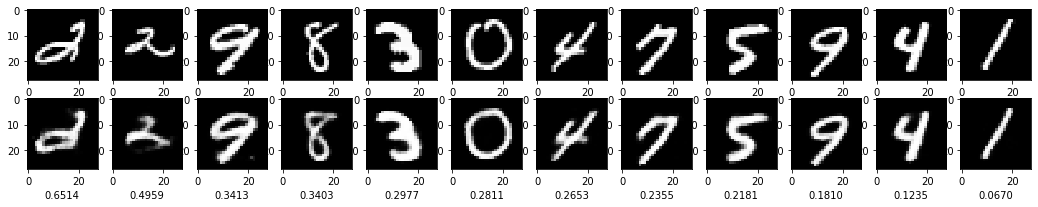

In [24]:
img_df = show_reconstructions(stacked_ae)
print("Top row are Original images and bottom row are Decoded images with loss metric from high to low:")

#save_fig("reconstruction_plot")

# img_df

Top row are Original images and bottom row are Decoded images with loss metric from high to low:


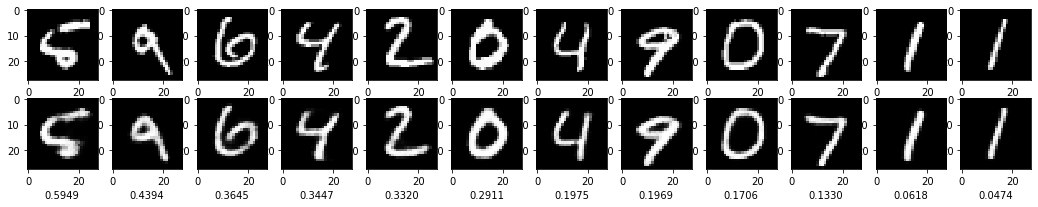

In [25]:
test_img_df = show_reconstructions(stacked_ae, X_test, 12)
print("Top row are Original images and bottom row are Decoded images with loss metric from high to low:")
#save_fig("reconstruction_plot")
# test_img_df.head(12)

**We will extract new features from the Stacked Autoencoder by useing two methods and compare the results to make sure they're identical. One method is simply using the predict function of the Encoder and the other method is using the Keras.function() method**

In [26]:
stacked_encoder.predict(X_test).shape, stacked_encoder.predict(X_test)

((10000, 29),
 array([[-1.7580993,  2.1099563, -1.7580993, ..., -1.7580993, -1.7580993,
         -1.7580945],
        [-1.7580993,  7.168458 , -1.7580993, ..., -1.7580993, -1.7580993,
         -1.7580993],
        [-1.7580993,  1.4230533, -1.758099 , ..., -1.7580993, -1.7580974,
         -1.7580416],
        ...,
        [-1.7580993,  6.7270727, -1.7580993, ..., -1.7580993, -1.7580993,
         -1.7580993],
        [-1.7580993,  5.477454 , -1.7580993, ..., -1.7580993, -1.7580993,
         -1.7580993],
        [-1.7580993,  9.333678 , -1.7580993, ..., -1.7580993, -1.7580993,
         -1.7580993]], dtype=float32))

In [27]:
# REFERENCE: https://keras.io/getting-started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer
from keras import backend as K

# with a Sequential model
get_3rd_layer_output = K.function([stacked_encoder.layers[0].input, K.learning_phase()],
                                  [stacked_encoder.layers[6].output])

# output in test mode = 0
stacked_encoder_layer_output_test = get_3rd_layer_output([X_test, 0])[0]
print(stacked_encoder_layer_output_test.shape, stacked_encoder_layer_output_test)

# output in valid/test mode = 0
stacked_encoder_layer_output_val = get_3rd_layer_output([X_valid, 0])[0]
print(stacked_encoder_layer_output_val.shape, stacked_encoder_layer_output_val)

# output in train mode = 1
stacked_encoder_layer_output_train = get_3rd_layer_output([X_train, 1])[0]
print(stacked_encoder_layer_output_train.shape, stacked_encoder_layer_output_train)


# output in test mode = 0
# USE THIS to combine with original data set
#layer_output_test = get_3rd_layer_output([X_test, 0])[0]

(10000, 29) [[-1.7580993  2.1099532 -1.7580993 ... -1.7580993 -1.7580993 -1.7580945]
 [-1.7580993  7.1684575 -1.7580993 ... -1.7580993 -1.7580993 -1.7580993]
 [-1.7580993  1.4230521 -1.758099  ... -1.7580993 -1.7580974 -1.7580416]
 ...
 [-1.7580993  6.7270727 -1.7580993 ... -1.7580993 -1.7580993 -1.7580993]
 [-1.7580993  5.4774513 -1.7580993 ... -1.7580993 -1.7580993 -1.7580993]
 [-1.7580993  9.333682  -1.7580993 ... -1.7580993 -1.7580993 -1.7580993]]
(5000, 29) [[-1.7580993  5.2821465 -1.7580993 ... -1.7580993 -1.7580992 -1.7580991]
 [-1.7580993  5.1363554 -1.7580993 ... -1.7580993 -1.7580993 -1.7580993]
 [-1.7580993  4.262363  -1.7580993 ... -1.7580993 -1.7580993 -1.7580993]
 ...
 [-1.7580993  6.0841684 -1.7580993 ... -1.7580993 -1.7580993 -1.7580993]
 [-1.7580993  6.14877   -1.7580993 ... -1.7580993 -1.7580993 -1.7580993]
 [-1.7580993 11.422663  -1.7580993 ... -1.7580993 -1.7580993 -1.758099 ]]
(55000, 29) [[-1.7580993  -0.22988008 -1.7580993  ... -1.7580993  -1.7580993
  -1.7580993

Using TensorFlow backend.


**We see that the both methods extracted the middle layer of Autoencoder which has 29 new (or 'fake') features and it will be added to the original MNIST data set**

**We now reshape data sets from 3d to 2d so we can later add 29 features to them.**

In [28]:
X_test_2d = X_test.reshape((-1, X_test.shape[1]*X_test.shape[2]))
X_test_2d.shape, X_test_2d

((10000, 784),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32))

In [29]:
X_test.shape, X_test_2d.shape, stacked_encoder_layer_output_test.shape

((10000, 28, 28), (10000, 784), (10000, 29))

In [30]:
X_train_2d = X_train.reshape((-1, X_train.shape[1]*X_train.shape[2]))
X_train_2d.shape, X_train_2d

((55000, 784),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32))

In [31]:
X_valid_2d = X_valid.reshape((-1, X_valid.shape[1]*X_valid.shape[2]))
X_valid_2d.shape, X_valid_2d

((5000, 784),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32))

**We start adding 29 features to Train, Valid and Test sets**

In [32]:
X_train_2d_new = np.hstack((X_train_2d, stacked_encoder_layer_output_train))
X_train_2d_new.shape

(55000, 813)

In [33]:
X_valid_2d_new = np.hstack((X_valid_2d, stacked_encoder_layer_output_val))
X_valid_2d_new.shape

(5000, 813)

In [34]:
X_test_2d_new = np.hstack((X_test_2d, stacked_encoder_layer_output_test))
X_test_2d_new.shape

(10000, 813)

**We created a Multi-layered Supervised model (called super_model) to train and test on the MNIST data set. We will first perform training and testing on the combined 29 plus 784 features. Then compare those results to the training and testing of only the original 784 features:** 

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 5s 94us/sample - loss: 0.4124 - accuracy: 0.8715 - val_loss: 0.1161 - val_accuracy: 0.9662
Epoch 2/20
55000/55000 [==============================] - 5s 91us/sample - loss: 0.2158 - accuracy: 0.9354 - val_loss: 0.1125 - val_accuracy: 0.9680
Epoch 3/20
55000/55000 [==============================] - 5s 87us/sample - loss: 0.1807 - accuracy: 0.9464 - val_loss: 0.1071 - val_accuracy: 0.9684
Epoch 4/20
55000/55000 [==============================] - 5s 87us/sample - loss: 0.1603 - accuracy: 0.9529 - val_loss: 0.0949 - val_accuracy: 0.9714
Epoch 5/20
55000/55000 [==============================] - 5s 89us/sample - loss: 0.1452 - accuracy: 0.9567 - val_loss: 0.0754 - val_accuracy: 0.9768
Epoch 6/20
55000/55000 [==============================] - 5s 85us/sample - loss: 0.1336 - accuracy: 0.9606 - val_loss: 0.0994 - val_accuracy: 0.9726
Epoch 7/20
55000/55000 [==============================] -

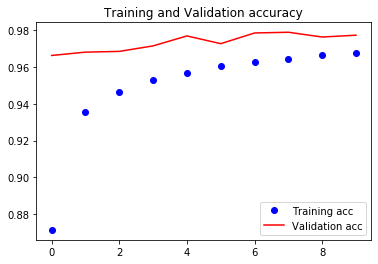

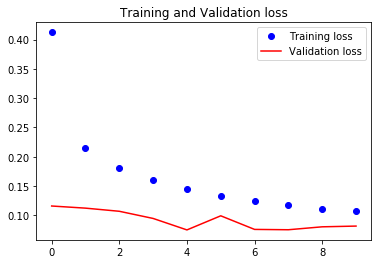

In [35]:
keras.backend.clear_session()
# This super model uses the new 29 features added to 784
new_super_model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(813,)),
    keras.layers.Dense(40, activation="selu"),
    keras.layers.Dropout(0.10),
    keras.layers.Dense(60, activation="selu"),
    keras.layers.Dropout(0.10),
    keras.layers.Dense(80, activation="selu"),
    keras.layers.Dropout(0.10),
    keras.layers.Dense(58, activation="selu"),
    keras.layers.Dropout(0.10),
    keras.layers.Dense(38, activation="selu"),
    keras.layers.Dense(10, activation="sigmoid")])



new_super_model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.Adam(),
              metrics=["accuracy"])

# This will check loss trend and stop if trend does not change
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5)
# This will rollback and save best model fit checkpoint
checkpoint_cb = keras.callbacks.ModelCheckpoint("new_mnist_super_model.h5", save_best_only=True)

# We are using both the X_train_2d_new and X_valid_2d_new dataset which has the new 29 features added to 784
new_super_history = new_super_model.fit(X_train_2d_new, y_train, epochs=20,
                    validation_data=(X_valid_2d_new, y_valid),
                    callbacks=[early_stopping_cb, checkpoint_cb])

# Removed # validation_data=(X_valid, y_valid), # from super_history
# Removed # callbacks=[early_stopping_cb, checkpoint_cb]) # uses val_loss

new_acc = new_super_history.history['accuracy']
new_val_acc = new_super_history.history['val_accuracy']
new_loss = new_super_history.history['loss']
new_val_loss = new_super_history.history['val_loss']

new_epochs = range(len(new_loss))

plt.plot(new_epochs, new_acc, 'bo', label='Training acc')
plt.plot(new_epochs, new_val_acc, 'b', label='Validation acc', color='red')
plt.title('Training and Validation accuracy')
plt.legend()
#plt.savefig('final_curve_fit_acc.png')
plt.figure()

plt.plot(new_epochs, new_loss, 'bo', label='Training loss')
plt.plot(new_epochs, new_val_loss, 'b', label='Validation loss', color='red')
plt.title('Training and Validation loss')
plt.legend()

#plt.savefig('final_curve_fit_loss.png')
plt.show()

In [36]:
new_super_model = keras.models.load_model("new_mnist_super_model.h5") # rollback to best model
new_super_model.evaluate(X_test_2d_new, y_test)

10000/10000 [==============================] - 1s 61us/sample - loss: 0.0918 - accuracy: 0.9727


[0.09184804653786123, 0.9727]

In [37]:
new_test_pred = new_super_model.predict(X_test_2d_new)

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 6s 100us/sample - loss: 0.4551 - accuracy: 0.8614 - val_loss: 0.1591 - val_accuracy: 0.9500
Epoch 2/20
55000/55000 [==============================] - 5s 89us/sample - loss: 0.2643 - accuracy: 0.9214 - val_loss: 0.1361 - val_accuracy: 0.9600
Epoch 3/20
55000/55000 [==============================] - 5s 87us/sample - loss: 0.2263 - accuracy: 0.9315 - val_loss: 0.1225 - val_accuracy: 0.9664
Epoch 4/20
55000/55000 [==============================] - 5s 88us/sample - loss: 0.1962 - accuracy: 0.9400 - val_loss: 0.1184 - val_accuracy: 0.9622
Epoch 5/20
55000/55000 [==============================] - 5s 89us/sample - loss: 0.1756 - accuracy: 0.9469 - val_loss: 0.0944 - val_accuracy: 0.9714
Epoch 6/20
55000/55000 [==============================] - 5s 87us/sample - loss: 0.1644 - accuracy: 0.9503 - val_loss: 0.0899 - val_accuracy: 0.9742
Epoch 7/20
55000/55000 [==============================] 

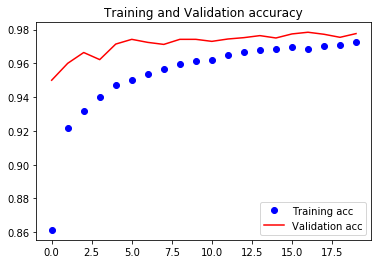

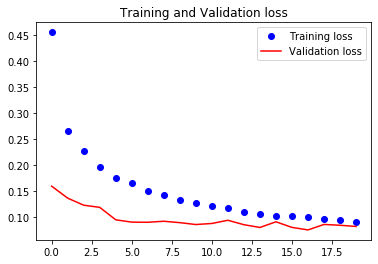

In [38]:
keras.backend.clear_session()
# This super model uses only the original 784 features
super_model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(40, activation="selu"),
    keras.layers.Dropout(0.10),
    keras.layers.Dense(60, activation="selu"),
    keras.layers.Dropout(0.10),
    keras.layers.Dense(80, activation="selu"),
    keras.layers.Dropout(0.10),
    keras.layers.Dense(58, activation="selu"),
    keras.layers.Dropout(0.10),
    keras.layers.Dense(38, activation="selu"),
    keras.layers.Dense(10, activation="sigmoid")])

super_model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.Adam(),
              metrics=["accuracy"])

# This will check loss trend and stop if trend does not change
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5)
# This will rollback and save best model fit checkpoint
checkpoint_cb = keras.callbacks.ModelCheckpoint("mnist_super_model.h5", save_best_only=True)


super_history = super_model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb, checkpoint_cb])

# Removed # validation_data=(X_valid, y_valid), # from super_history
# Removed # callbacks=[early_stopping_cb, checkpoint_cb]) # uses val_loss

acc = super_history.history['accuracy']
val_acc = super_history.history['val_accuracy']
loss = super_history.history['loss']
val_loss = super_history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc', color='red')
plt.title('Training and Validation accuracy')
plt.legend()
#plt.savefig('final_curve_fit_acc.png')
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss', color='red')
plt.title('Training and Validation loss')
plt.legend()

#plt.savefig('final_curve_fit_loss.png')
plt.show()

In [39]:
super_model = keras.models.load_model("mnist_super_model.h5") # rollback to best model
super_model.evaluate(X_test, y_test)

10000/10000 [==============================] - 1s 73us/sample - loss: 0.0914 - accuracy: 0.9734


[0.09141164272893221, 0.9734]

**We are just observing how the small sample of test data performs on super_model predictions:**

In [40]:
# Using the super_model (original 784 features) to observe small sample of predictions
pred = super_model.predict(X_test)

In [41]:
missed_idx = []
correct_idx = []
pred_rnk_1 = []
pred_rnk_2 = []
missed = 0
correct = 0
for idx in range(0, 10000):
    pred_idxsort = pred[idx].argsort()
    pred_rnk_1.append(pred_idxsort[-1])
    pred_rnk_2.append(pred_idxsort[-2])
    if (y_test[idx] != pred_idxsort[-1]):
        missed_idx.append(idx)
        #print(idx,'',y_test[idx],'',pred_rnk_1,'',pred_rnk_2)
        missed+=1
    else:
        correct_idx.append(idx)
        #print(idx,'',y_test[idx],'',pred_rnk_1,'',pred_rnk_2)
        correct+=1

In [42]:
incorrect_indices = missed_idx
correct_indices = correct_idx
testX = X_test
testy = y_test
predicted_classes = pred_rnk_1

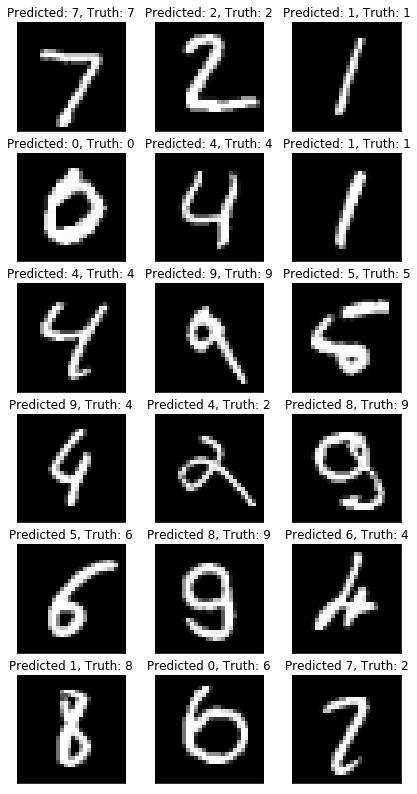

In [43]:
# adapt figure size to accomodate 18 subplots
plt.rcParams['figure.figsize'] = (7,14)

figure_evaluation = plt.figure()

# plot 9 correct predictions
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(6,3,i+1)
    plt.imshow(testX[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title(
      "Predicted: {}, Truth: {}".format(predicted_classes[correct],
                                        testy[correct]))
    plt.xticks([])
    plt.yticks([])

# plot 9 incorrect predictions
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(6,3,i+10)
    plt.imshow(testX[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title(
      "Predicted {}, Truth: {}".format(predicted_classes[incorrect], 
                                       testy[incorrect]))
    plt.xticks([])
    plt.yticks([])

In [44]:
# Using the new_super_model (29 plus 784 features) to observe small sample of predictions
new_pred = new_super_model.predict(X_test_2d_new)
pred = new_pred

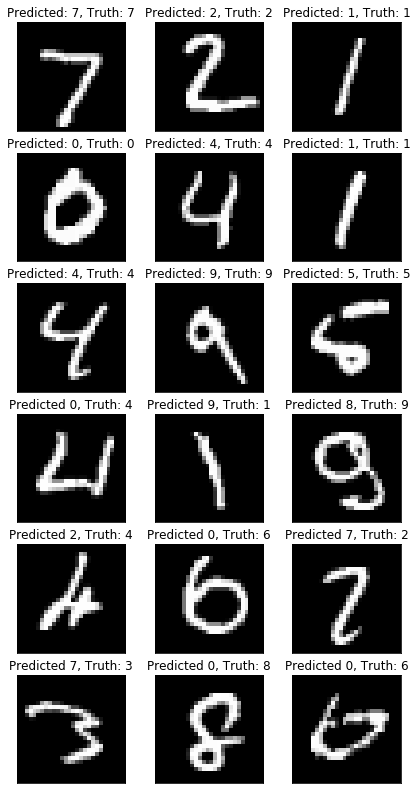

In [45]:
missed_idx = []
correct_idx = []
pred_rnk_1 = []
pred_rnk_2 = []
missed = 0
correct = 0
for idx in range(0, 10000):
    pred_idxsort = pred[idx].argsort()
    pred_rnk_1.append(pred_idxsort[-1])
    pred_rnk_2.append(pred_idxsort[-2])
    if (y_test[idx] != pred_idxsort[-1]):
        missed_idx.append(idx)
        #print(idx,'',y_test[idx],'',pred_rnk_1,'',pred_rnk_2)
        missed+=1
    else:
        correct_idx.append(idx)
        #print(idx,'',y_test[idx],'',pred_rnk_1,'',pred_rnk_2)
        correct+=1
        
incorrect_indices = missed_idx
correct_indices = correct_idx
testX = X_test
testy = y_test
predicted_classes = pred_rnk_1

# adapt figure size to accomodate 18 subplots
plt.rcParams['figure.figsize'] = (7,14)

figure_evaluation = plt.figure()

# plot 9 correct predictions
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(6,3,i+1)
    plt.imshow(testX[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title(
      "Predicted: {}, Truth: {}".format(predicted_classes[correct],
                                        testy[correct]))
    plt.xticks([])
    plt.yticks([])

# plot 9 incorrect predictions
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(6,3,i+10)
    plt.imshow(testX[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title(
      "Predicted {}, Truth: {}".format(predicted_classes[incorrect], 
                                       testy[incorrect]))
    plt.xticks([])
    plt.yticks([])

In [47]:
# Get total runtime in minutes
(time.time() - start_time)/60

5.483909956614176